<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6853 entries, 0 to 6852
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   6853 non-null   int64 
 1   Title        6853 non-null   object
 2   type_area    6853 non-null   object
 3   value_area   6853 non-null   object
 4   status       6853 non-null   object
 5   floor        6845 non-null   object
 6   transaction  6832 non-null   object
 7   furnishing   6816 non-null   object
 8   facing       6764 non-null   object
 9   price        6853 non-null   object
 10  price_sqft   6405 non-null   object
 11  description  5087 non-null   object
dtypes: int64(1), object(11)
memory usage: 642.6+ KB


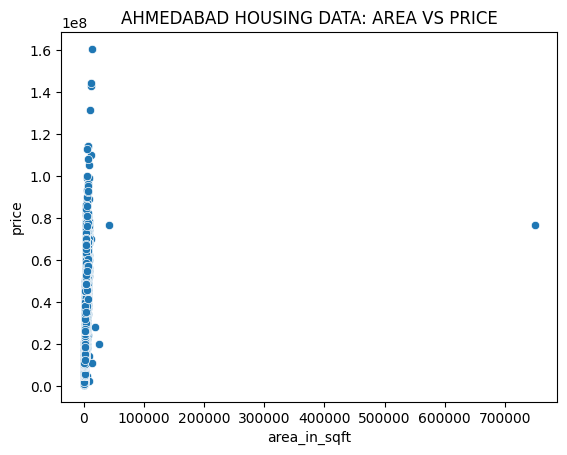

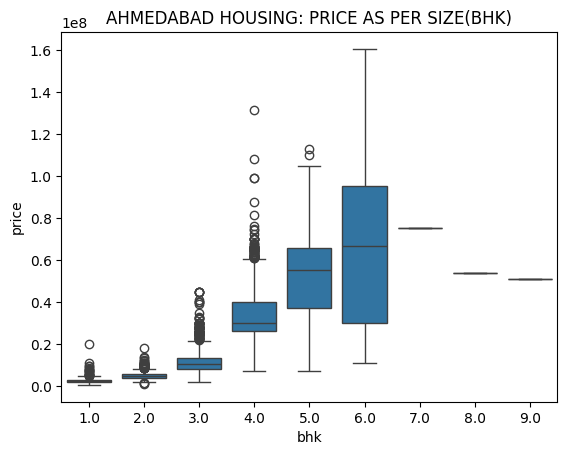

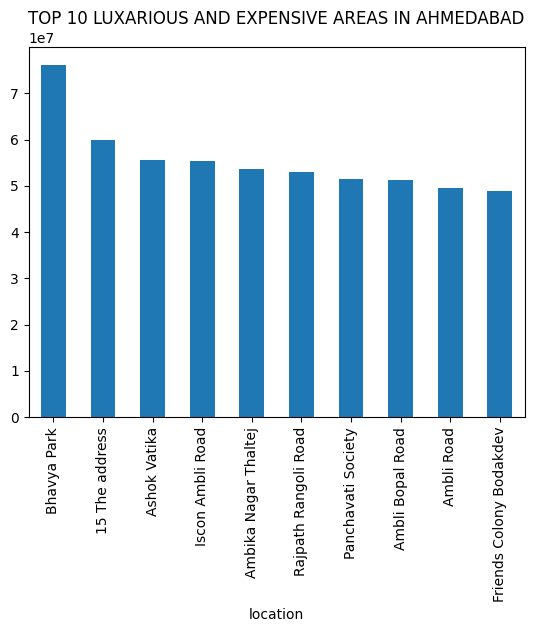

Training start
Training done
R2: 0.7873851689554409
MAE: 4222442.055139029


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def convert_sqft(area):
    if pd.isna(area):
        return None
    
    area = str(area).lower().replace(",", "").strip()
    
    if "sqyrd" in area:
        num = float(area.replace("sqyrd", "").strip())
        return num * 9   # 1 sqyrd = 9 sqft
    
    if "sqft" in area:
        num = float(area.replace("sqft", "").strip())
        return num
    
    return None
        
def convert_price(price):
    if pd.isna(price):
        return None
    
    price = str(price).lower().replace("₹", "").replace(",", "").strip()
    
    if "call" in price:
        return None
    
    if "cr" in price:
        num = float(price.replace("cr", "").strip())
        return num * 10000000
    
    if "lac" in price or "lakh" in price:
        num = float(price.replace("lac", "").replace("lakh", "").strip())
        return num * 100000
    
    return None

def convert_price_sqft(x):
    if pd.isna(x):
        return None
    
    x = str(x).lower().replace("₹", "").replace(",", "").strip()
    
    if "per sqft" in x:
        return float(x.replace("per sqft", "").strip())
    
    try:
        return float(x)
    except:
        return None


df=pd.read_csv("ahmedabad.csv")
df.head()

df.info()
df.describe()
df.columns
df["bhk"] = df["Title"].str.extract(r"(\d+)\s*BHK")
df["bhk"] = pd.to_numeric(df["bhk"], errors="coerce")
df["bhk"] = df["bhk"].fillna(1)
df["area_part"]=df["Title"].str.extract(r"in (.*) Ahmedabad")
df["scheme"]=df["area_part"].str.split(",").str[0].str.strip()
df["location"]=df["area_part"].str.split(",").str[-1].str.strip()
df["area_in_sqft"] = df["value_area"].apply(convert_sqft)
df["price"]=df["price"].apply(convert_price)
df["price_per_sqft"]=df["price_sqft"].apply(convert_price_sqft)


df.drop(columns=["area_part"], inplace=True)
df=df[[
    "location",
    "area_in_sqft",
    "bhk",
    "price",
    "price_per_sqft"
]]

df=df.dropna(subset=["location","area_in_sqft","bhk","price"])

df["price_per_sqft"]=df["price"]/df["area_in_sqft"]

df=df[df["area_in_sqft"]/df["bhk"] >250]

df=df[df["price_per_sqft"] < df["price_per_sqft"].quantile(0.99)]

sns.scatterplot(x="area_in_sqft",y="price",data=df)
plt.title("AHMEDABAD HOUSING DATA: AREA VS PRICE")
plt.show()


sns.boxplot(x="bhk", y="price", data=df)
plt.title("AHMEDABAD HOUSING: PRICE AS PER SIZE(BHK)")
plt.show()

top_loc=df.groupby("location")["price"].mean().sort_values(ascending=False).head(10)
top_loc.plot(kind="bar")
plt.title("TOP 10 LUXARIOUS AND EXPENSIVE AREAS IN AHMEDABAD")
plt.show()

#grouping rare locations
loc_counts = df["location"].value_counts()
df["location"] = df["location"].apply(
    lambda x: x if loc_counts[x] >= 20 else "other"
)

df = df[df["area_in_sqft"].between(300, 5000)]
#TRAINING THE DATASET

df_ml = pd.get_dummies(df, columns=["location"], drop_first=True)

X = df_ml.drop(
    ["price", "price_per_sqft"],
    axis=1,
    errors="ignore",
)
Y = np.log1p(df_ml["price"])

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_absolute_error

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

model = Pipeline([
    ("scaler", StandardScaler()),
    ("ridge", Ridge(alpha=1.0))
])

print("Training start")
model.fit(X_train, Y_train)
print("Training done")

Y_pred = model.predict(X_test)

# back-transform
Y_pred_actual = np.expm1(Y_pred)
Y_test_actual = np.expm1(Y_test)

print("R2:", r2_score(Y_test_actual, Y_pred_actual))
print("MAE:", mean_absolute_error(Y_test_actual, Y_pred_actual))





In [2]:
import pickle

pickle.dump(model, open("Ahmedabad_flats_price_model.pkl", "wb"))
print("Model saved")

Model saved


In [3]:
import json

cols = list(X.columns)
json.dump(cols, open("model_columns.json", "w"))